In [1]:
import math
import scipy.special
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_mldata

# Generate Data (MNIST or Gaussian mixture)

In [2]:
def gen_data(testcase,Tr,Te,prop,means=None,covs=None):
    rng = np.random
    
    if testcase is 'MNIST':
        mnist=fetch_mldata('MNIST original')
        X,y = mnist.data,mnist.target
        X_train_full, X_test_full = X[:60000], X[60000:]
        y_train_full, y_test_full = y[:60000], y[60000:]

        selected_target = [7,9]
        K=len(selected_target)
        X_train = np.array([]).reshape(p,0)
        X_test = np.array([]).reshape(p,0)        
        
        y_train = []
        y_test = []
        ind=0
        for i in selected_target:
            locate_target_train = np.where(y_train_full==i)[0][range(np.int(prop[ind]*Tr))]
            locate_target_test  = np.where(y_test_full==i)[0][range(np.int(prop[ind]*Te))]
            X_train = np.concatenate( (X_train,X_train_full[locate_target_train].T),axis=1)
            y_train = np.concatenate( (y_train,2*(ind-K/2+.5)*np.ones(np.int(Tr*prop[ind]))) )
            X_test  = np.concatenate( (X_test,X_test_full[locate_target_test].T),axis=1)
            y_test = np.concatenate( (y_test,2*(ind-K/2+.5)*np.ones(np.int(Te*prop[ind]))) )
            ind+=1                       
        
        X_train = X_train - np.mean(X_train,axis=1).reshape(p,1)
        X_train = X_train*np.sqrt(784)/np.sqrt(np.sum(X_train**2,(0,1))/Tr)
        
        X_test = X_test - np.mean(X_test,axis=1).reshape(p,1)
        X_test = X_test*np.sqrt(784)/np.sqrt(np.sum(X_test**2,(0,1))/Te)
        
    else:
        X_train = np.array([]).reshape(p,0)
        X_test = np.array([]).reshape(p,0)       
        y_train = []
        y_test = []
        K = len(prop)
        for i in range(K):            
            X_train = np.concatenate((X_train,rng.multivariate_normal(means[i],covs[i],size=np.int(Tr*prop[i])).T),axis=1)
            X_test  = np.concatenate((X_test, rng.multivariate_normal(means[i],covs[i],size=np.int(Te*prop[i])).T),axis=1)
            y_train = np.concatenate( (y_train,2*(i-K/2+.5)*np.ones(np.int(Tr*prop[i]))) )
            y_test = np.concatenate( (y_test,2*(i-K/2+.5)*np.ones(np.int(Te*prop[i]))) )            
            
    X_train = X_train/math.sqrt(p)
    X_test  = X_test/math.sqrt(p)
            
    return X_train, X_test, y_train, y_test
        

# Generate $\sigma(\cdot)$ activation functions

In [3]:
def gen_sig(fun,Z,polynom=None):
    
    if fun is 'poly2':
        sig = polynom[0]*Z**2+polynom[1]*Z+polynom[2]
    elif fun is 'ReLu':
        sig = np.maximum(Z,0)
    elif fun is 'sign':
        sig = np.sign(Z)
    elif fun is 'posit':
        sig = (Z>0).astype(int)
    elif fun is 'erf':
        sig = scipy.special.erf(Z)
    elif fun is 'cos':
        sig = np.cos(Z)
    elif fun is 'abs':
        sig = np.abs(Z)
        
    return sig

# Generate matrices $\Phi_{AB}$

In [4]:
def gen_Phi(fun,A,B,polynom=None,distrib=None,nu=None):
    normA = np.sqrt(np.sum(A**2,axis=0))
    normB = np.sqrt(np.sum(B**2,axis=0))
    
    AB = A.T @ B
    angle_AB = np.minimum( (1/normA).reshape((len(normA),1)) * AB * (1/normB).reshape( (1,len(normB)) ) ,1.)
      
    if fun is 'poly2':
        mom = {'gauss': [1,0,3],'bern': [1,0,1],'bern_skewed': [1,-2/math.sqrt(3),7/3],'student':[1,0,6/(nu-4)+3]}
        A2 = A**2
        B2 = B**2
        Phi = polynom[0]**2*(mom[distrib][0]**2*(2*AB**2+(normA**2).reshape((len(normA),1))*(normB**2).reshape((1,len(normB))) )+(mom[distrib][2]-3*mom[distrib][0]**2)*(A2.T@B2))+polynom[1]**2*mom[distrib][0]*AB+polynom[1]*polynom[0]*mom[distrib][1]*(A2.T@B+A.T@B2)+polynom[2]*polynom[0]*mom[distrib][0]*( (normA**2).reshape( (len(normA),1) )+(normB**2).reshape( (1,len(normB)) ) )+polynom[2]**2
        
    elif fun is 'ReLu':
        Phi = 1/(2*math.pi)* normA.reshape((len(normA),1)) * (angle_AB*np.arccos(-angle_AB)+np.sqrt(1-angle_AB**2)) * normB.reshape( (1,len(normB)) )
        
    elif fun is 'abs':
        Phi = 2/math.pi* normA.reshape((len(normA),1)) * (angle_AB*np.arcsin(angle_AB)+np.sqrt(1-angle_AB**2)) * normB.reshape( (1,len(normB)) )
        
    elif fun is 'posit':
        Phi = 1/2-1/(2*math.pi)*np.arccos(angle_AB)
        
    elif fun is 'sign':
        Phi = 1-2/math.pi*np.arccos(angle_AB)
        
    elif fun is 'cos':
        Phi = np.exp(-.5*( (normA**2).reshape((len(normA),1))+(normB**2).reshape((1,len(normB))) ))*np.cosh(AB)
        
    elif fun is 'erf':
        Phi = 2/math.pi*np.arcsin(2*AB/np.sqrt((1+2*(normA**2).reshape((len(normA),1)))*(1+2*(normB**2).reshape((1,len(normB))))))

    return Phi

# Generate $E_{\rm train}$ and $E_{\rm test}$

In [5]:
def gen_E_th():
    d=0
    dt=-1

    while np.abs(d-dt)>1e-6:
        dt=d
        d=np.mean(L/(L*n/Tr/(1+d)+gamma))
        
    L_psi = L*n/Tr/(1+d)
    L_bQ = 1/(L_psi+gamma)

    # E_train
    E_train_th = gamma**2*np.mean(Uy_train**2*L_bQ**2*(1/n*np.sum(L_psi*L_bQ**2)/(1-1/n*np.sum(L_psi**2*L_bQ**2))*L_psi+1)) 
    
    #E_test
    E_test_th = np.mean((y_test-n/Tr/(1+d)*UPhi_cross.T@(L_bQ*Uy_train))**2)+(1/n*np.sum(Uy_train**2*L_psi*L_bQ**2))/(1-1/n*np.sum(L_psi**2*L_bQ**2))*(np.mean((n/Tr/(1+d))*D_Phi_test)-Tr/Te*np.mean( (n/Tr/(1+d))**2*D_UPhi_cross2*(1+gamma*L_bQ)*L_bQ))
    
    return E_train_th,E_test_th
    

# Main code

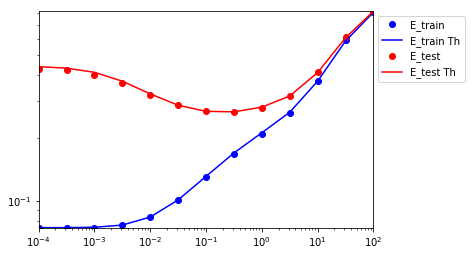

In [9]:
## Parameter setting
n=512
p=256
Tr=1024           # Training length
Te=Tr             # Testing length

prop=[.5,.5]       # proportions of each class
K=len(prop)        # number of data classes

gammas = [10**x for x in np.arange(-4,2.25,.5)] # Range of gamma for simulations

testcase='MNIST'   # testcase for simulation, among 'iid','means','var','orth','MNIST'
sigma='erf'       # activation function, among 'ReLu', 'sign', 'posit', 'erf', 'poly2', 'cos', 'abs'


# Only used for sigma='poly2'
polynom=[-.5,0,1]  # sigma(t)=polynom[0].t²+polynom[1].t+polynom[2]
distrib='student'  # distribution of Wij, among 'gauss','bern','bern_skewed','student'

# Only used for sigma='poly2' and distrib='student'
nu=7             # degrees of freedom of Student-t distribution
        

## Generate X_train,X_test,y_train,y_test
if testcase is 'MNIST':
    p=784
    X_train,X_test,y_train,y_test = gen_data(testcase,Tr,Te,prop)
else:    
    means=[]
    covs=[]
    if testcase is 'iid':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append(np.eye(p))
    elif testcase is 'mixed':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),3*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append(np.eye(p)*(1+6*i/np.sqrt(p)))
    elif testcase is 'means':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append(np.eye(p))
    elif testcase is 'var':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append(np.eye(p)*(1+8*i/np.sqrt(p)))
    elif testcase is 'orth':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append( np.diag(np.concatenate( (np.ones(np.int(np.sum(prop[0:i]*p))),4*np.ones(np.int(prop[i]*p)),np.ones(np.int(np.sum(prop[i+1:]*p))) ) ) ))
            
    X_train,X_test,y_train,y_test = gen_data(testcase,Tr,Te,prop,means,covs)

##Theory
Phi=gen_Phi(sigma,X_train,X_train,polynom,distrib,nu)
L,U = np.linalg.eigh(Phi)
Phi_cross = gen_Phi(sigma,X_train,X_test,polynom,distrib,nu)
UPhi_cross = U.T@Phi_cross
D_UPhi_cross2 = np.sum(UPhi_cross**2,axis=1)

Phi_test = gen_Phi(sigma,X_test,X_test,polynom,distrib,nu)
D_Phi_test = np.diag(Phi_test)
Uy_train = U.T@y_train

E_train_th=np.zeros(len(gammas))
E_test_th =np.zeros(len(gammas))

ind=0
for gamma in gammas:
    E_train_th[ind],E_test_th[ind] = gen_E_th()
    ind+=1
    
## Simulations
loops = 10        # Number of generations of W to be averaged over

E_train=np.zeros(len(gammas))
E_test =np.zeros(len(gammas))


rng = np.random

for loop in range(loops):    
    if sigma is 'poly2':
        if distrib is 'student':
            W = rng.standard_t(nu,n*p).reshape(n,p)/np.sqrt(nu/(nu-2))
        elif distrib is 'bern':
            W = np.sign(rng.randn(n,p))
        elif distrib is 'bern_skewed':
            Z = rng.rand(n,p)
            W = (Z<.75)/np.sqrt(3)+(Z>.75)*(-np.sqrt(3))
        elif distrib is 'gauss':
            W = rng.randn(n,p)
    else:
        W = rng.randn(n,p)

    S_train = gen_sig(sigma,W @ X_train,polynom)
    SS = S_train.T @ S_train

    S_test = gen_sig(sigma, W @ X_test,polynom)

    ind = 0
    for gamma in gammas:

        inv_resolv = np.linalg.solve( SS/Tr+gamma*np.eye(Tr),y_train)
        beta = S_train @ inv_resolv/Tr
        z_train = S_train.T @ beta

        z_test = S_test.T @ beta


        E_train[ind] += gamma**2*np.linalg.norm(inv_resolv)**2/Tr/loops
        E_test[ind]  += np.linalg.norm(y_test-z_test)**2/Te/loops

        ind+=1   
    
#Plots    
p11,=plt.plot(gammas,E_train,'bo')
p21,=plt.plot(gammas,E_test,'ro')

p12,=plt.plot(gammas,E_train_th,'b-')
p22,=plt.plot(gammas,E_test_th,'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlim( gammas[0],gammas[-1] )
plt.ylim(np.amin( (E_train,E_train_th) ),np.amax( (E_test,E_test_th) ))
plt.legend([p11,p12,p21,p22], ["E_train", "E_train Th","E_test","E_test Th"],bbox_to_anchor=(1, 1), loc='upper left')
plt.show()
